In [9]:
import h5py
import numpy as np
import sys, os



# era sst

import xarray as xr
import numpy as np
import pandas as pd

import netCDF4
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
import matplotlib
from matplotlib import cm
import matplotlib.ticker as mticker
# import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# from matplotlib import animation
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
# plt.rcParams['animation.ffmpeg_path'] = '/home/gupt1075/FourCastNet/'


In [10]:


def extract_datetime_from_path(path):
    """
    Extracts the datetime from the given file path.
    
    Args:
        path (str): The file path.
        name, _ = os.path.splitext(basename)
    Returns:
        datetime.datetime: The extracted datetime.
    """
    # Split the path into its components
    basename, _ = os.path.splitext(os.path.basename(path))   
    components = basename.split('_')
    # print(components)
    
    # Find the index of the datetime components
    datetime_start_index = components.index('datetime')
    
    # Extract the datetime components
    date_components = components[datetime_start_index + 1:]
    
    # Parse the datetime components
    date_str = ' '.join(date_components)
    datetime_obj = datetime.strptime(date_str, '%d %B %H %Y')
    
    return datetime_obj


In [3]:
# inference_with_oos = "/scratch/gilbreth/wwtung/ERA5_expts_2013_oosrun"
# inference_without = "/scratch/gilbreth/wwtung/ERA5_expts_2013"


In [11]:
# plotting real and predicted for 2013 with oos

import glob
# directory= "/scratch/gilbreth/gupt1075/ERA5_expts_march_19/afno_backbone/222/"
username = "gupt1075"
# Use glob to find all the NumPy files in the directory
seq_real_files = [f"/home/{username}/FourCastNet_tutorial_expts/afno_backbone/222/seq_real_output_1_datetime_10_January_00_2018.npy"]
print(seq_real_files)
seq_real_datetimes = [extract_datetime_from_path(x) for x in seq_real_files]

# Use glob to find all the NumPy files in the directory
seq_pred_files = [f"/home/{username}/FourCastNet_tutorial_expts/afno_backbone/222/seq_pred_output_1_datetime_10_January_00_2018.npy"]
seq_pred_datetimes = [extract_datetime_from_path(x) for x in seq_pred_files]



print(seq_real_files)
print(seq_real_datetimes)

real_data = []
for file in seq_real_files:
    with open(file, 'rb') as file:
        real_data.append(np.load(file))


pred_data = []
for file in seq_pred_files:
    with open(file, 'rb') as file:
        pred_data.append(np.load(file))





['/home/gupt1075/FourCastNet_tutorial_expts/afno_backbone/222/seq_real_output_1_datetime_10_January_00_2018.npy']
['/home/gupt1075/FourCastNet_tutorial_expts/afno_backbone/222/seq_real_output_1_datetime_10_January_00_2018.npy']
[datetime.datetime(2018, 1, 10, 0, 0)]


In [12]:

print(real_data[0].shape)
print(pred_data[0].shape)
print(len(real_data))
print(len(pred_data))

(2, 20, 720, 1440)
(2, 20, 720, 1440)
1
1


In [14]:
def add_hours_to_datetime(start_datetime_obj, frames, default_timedelta = timedelta(hours = 6)):
    """
    Adds the given number of hours to the input datetime object.
    
    Args:
        datetime_obj (datetime.datetime): The input datetime object.
        hours (float): The number of hours to add.
        
    Returns:
        datetime.datetime: The resulting datetime object.
    """
    total_time_delta = frames *  default_timedelta
    new_datetime = start_datetime_obj + total_time_delta
    return new_datetime

idx_ics = 0
depth_from_ics = 0
# fld = "z500"
fld="t850"
channel_tags = {"u10": 0, "z500": 14, "2m_temperature": 2, "v10": 1, "t850": 5, "tcwv": 19}
channel=channel_tags[fld]


real = real_data[idx_ics][depth_from_ics,channel]
pred = pred_data[idx_ics][depth_from_ics,channel]


starting_datetime = seq_real_datetimes[idx_ics]
plotting_datetime = add_hours_to_datetime(starting_datetime, depth_from_ics).strftime("%d_%B_%Y_hour_%H:00:00_") 
print(f" pred_shape: {pred.shape}, real_shape: {real.shape}")


 pred_shape: (720, 1440), real_shape: (720, 1440)


In [15]:
#scale a model output field back to its original values after it has been standardized 
global_means = np.load('/scratch/gilbreth/wwtung/FourCastNet/additional/stats_v0/global_means.npy')
global_stds = np.load('/scratch/gilbreth/wwtung/FourCastNet/additional/stats_v0/global_stds.npy')

global_means.shape
global_stds.shape


# Retrieve the mean and std for the specific channel
mean_channel = global_means[0,channel,0,0]
std_channel = global_stds[0,channel,0,0]


# Reverse scale to original values
real = real * std_channel + mean_channel
pred = pred * std_channel + mean_channel


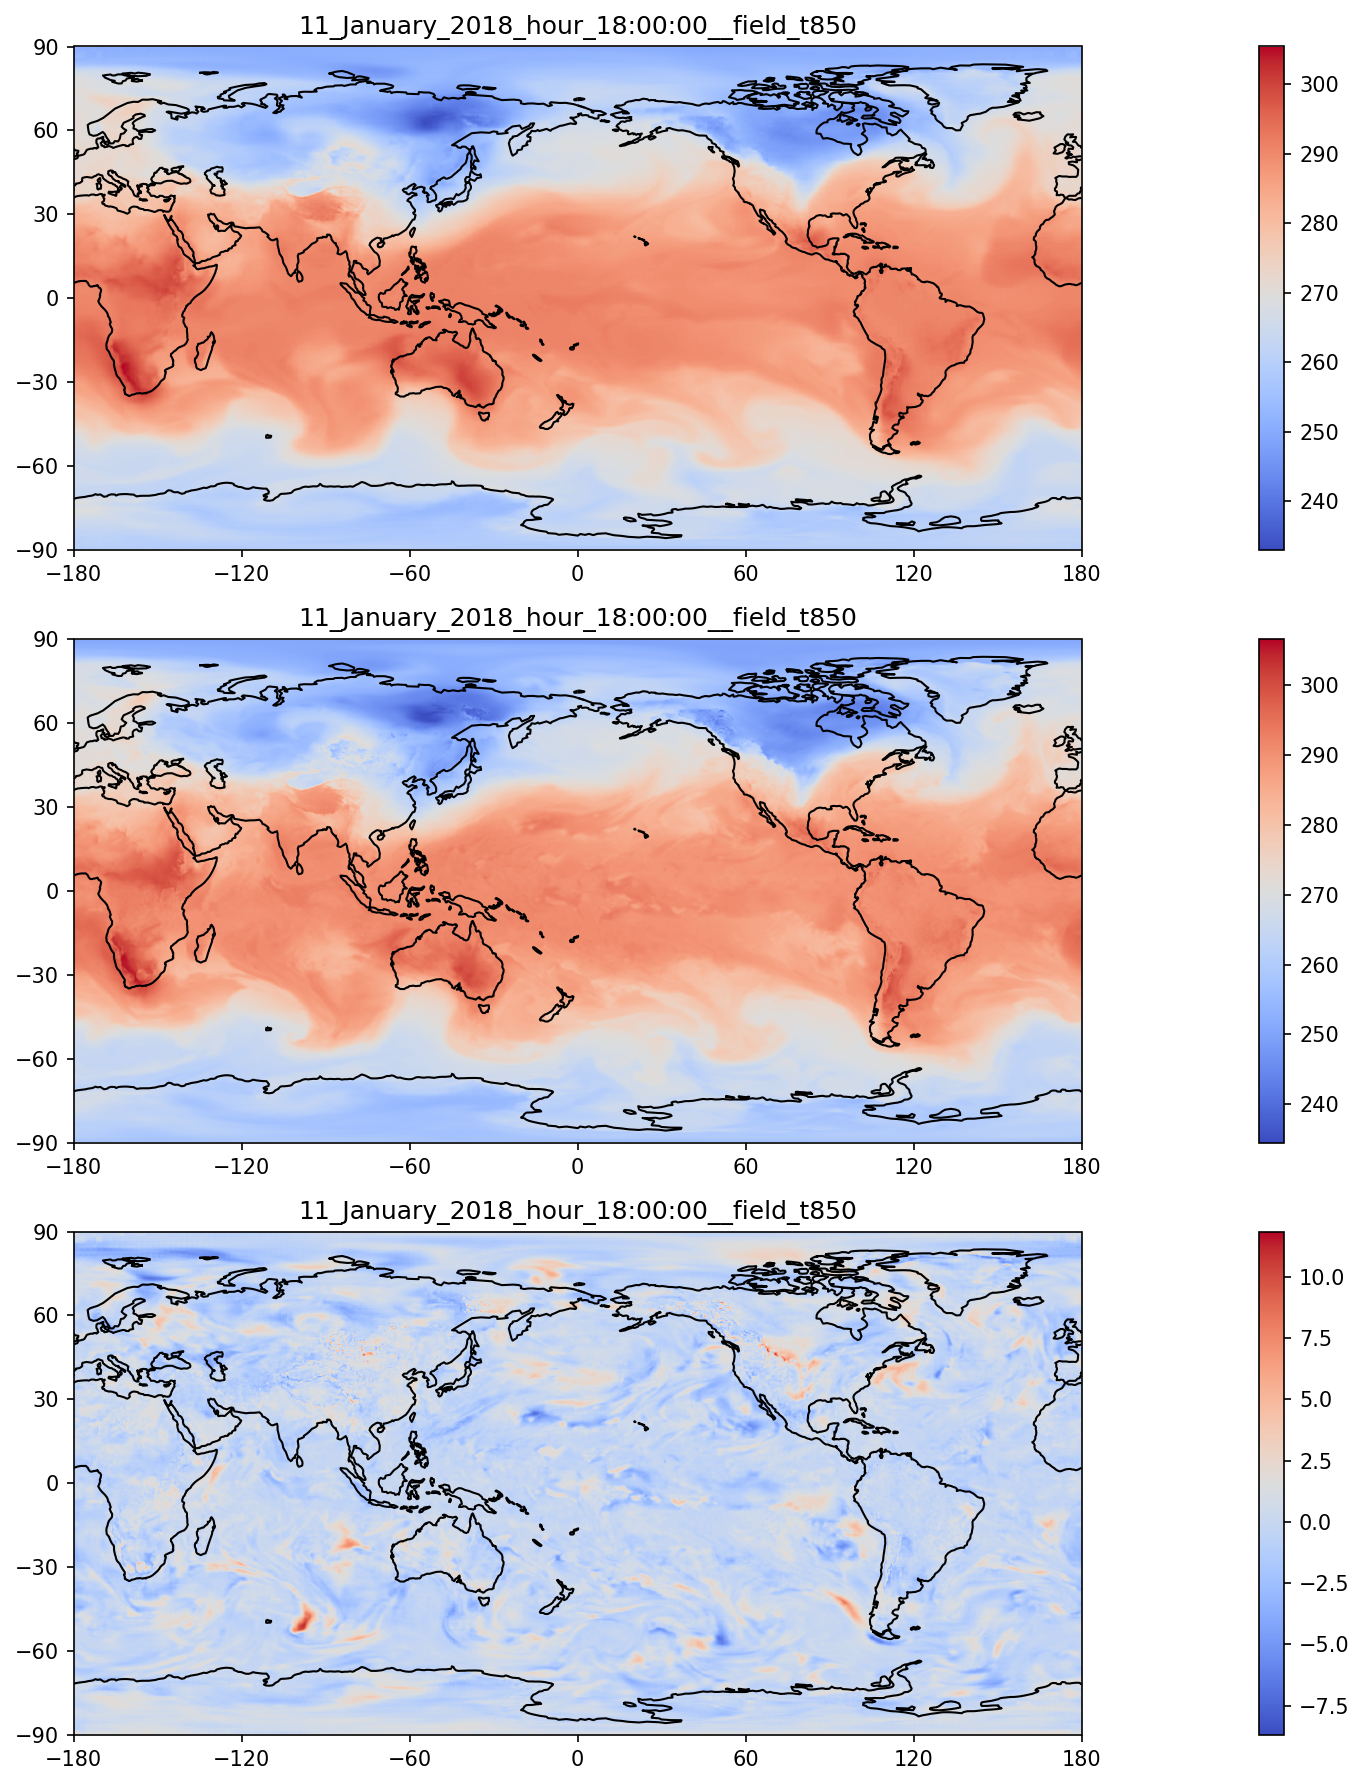

In [35]:

data = [pred, real, (pred-real) ]


# Create subplots
fig, axs = plt.subplots(3, 1, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(24,12))
# Plot the data
for i in range(3):
    ax = axs[i]
    ax.coastlines()
    out = ax.imshow(data[i], cmap="coolwarm", origin='upper', extent=[0, 360, -90, 90],  transform=ccrs.PlateCarree())
    # ax.set_extent([minlon, maxlon, -45, 45], ccrs.PlateCarree())
    # ax.gridlines(draw_labels=True, crs=proj)
    ax.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    fig.colorbar(out, ax=ax)
    ax.set_title(f"{plotting_datetime}_field_{fld}")
    # ax.contourf(lons, lats, sst, 60,
    # transform=ccrs.PlateCarree(central_longitude=180))


# Display the plot
fig.tight_layout()
plt.show()
